In [3]:
import pandas as pd
import logomaker
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import warnings
warnings.filterwarnings("ignore")

In [4]:
import coopgcpbm.modeler.plotlib as pl

## 1. Analysis on d=4 for ETS1-ETS1
Since we want to get information about anticoop, I created a training data that retains all information (i.e., it includes the anticoop and fail_cutoff sequences).

In [5]:
train_ee = pd.read_csv("train_ets1_ets1_w_anticoop.tsv", sep="\t")
train_ee_d4 = train_ee[train_ee["distance"] == 4]

### 1.a. Consensus motif for d=4
It looks like ETS1-ETS1 d=4 follows a specific GGAAGGAA composite motif with differences in the flanking regions.

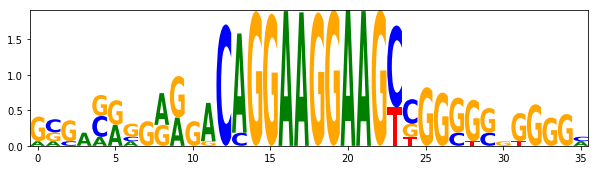

In [6]:
m = logomaker.alignment_to_matrix(train_ee_d4["Sequence"].tolist(), to_type="weight")
m[m < 0] = 0
logomaker.Logo(m)

Motifs from just the cooperative sequences are similar from the d=4 sequences in general

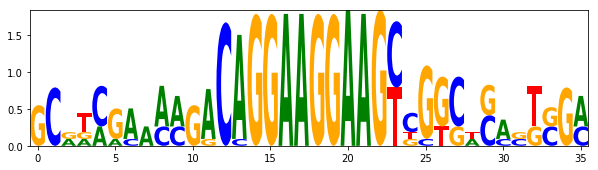

In [7]:
coop_ambiguous_seqs_d4 = train_ee_d4[train_ee_d4["label"] == "cooperative"]["Sequence"].tolist()
m = logomaker.alignment_to_matrix(coop_ambiguous_seqs_d4, to_type="weight")
m[m < 0] = 0
logomaker.Logo(m)

### 1.b. Label counts per orientation for d=4
Note that we converted all -/- into +/+

In [14]:
train_ee_d4[["orientation", "label"]].value_counts()

orientation  label          
+/+          cooperative        26
             fail_cutoff        24
             ambiguous          19
             independent        11
             anticooperative     2
-/+          ambiguous           1
+/-          fail_cutoff         1
dtype: int64

### 1.c. Binding site strength for d=4
Same conclusion as the general ETS1-ETS1 conclusion for the binding strength although it seems that the independent sequences have a very specific motifs for the stronger site,

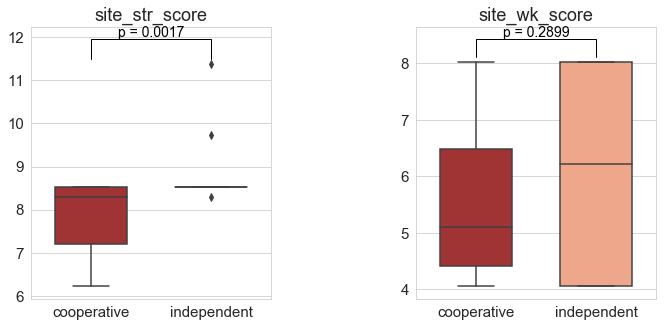

In [15]:
train_ee_d4_filtered = train_ee_d4[(train_ee_d4["label"] == "cooperative") | (train_ee_d4["label"] == "independent") ]
pl.plot_box_categories(train_ee_d4_filtered, incols=["site_str_score", "site_wk_score"], alternative="smaller", color = ["#b22222","#FFA07A"])
plt.show()

## 2. PWM binding scores vs ChIP-seq signals
Currently using all sequences instead of independent only

In [8]:
chip_ets1_k562 = pd.read_csv("chipseq_ets1_k562.tsv", sep="\t").rename(columns = {"sequence":"Sequence"})

In [9]:
pwm_vs_chip_k562 = chip_ets1_k562[["Sequence", "pileup_score"]]. \
        merge(train_ee[["Sequence","site_str_score", "site_wk_score"]],on="Sequence"). \
        rename(columns = {"site_str_score": "stronger_site", "site_wk_score": "weaker_site"})
print("#sequences in chip_k562 and ets1-ets1 training data:", pwm_vs_chip_k562.shape[0])
pwm_vs_chip_k562 = pd.melt(pwm_vs_chip_k562, id_vars=['Sequence', 'pileup_score'], 
                           value_vars=['stronger_site', 'weaker_site'],
                           var_name='site_type', value_name='pwm_score')

#sequences in chip_k562 and ets1-ets1 training data: 283


Pearson correlation
 site_type                  
stronger_site  pileup_score   -0.025989
weaker_site    pileup_score    0.057642
Name: pwm_score, dtype: float64


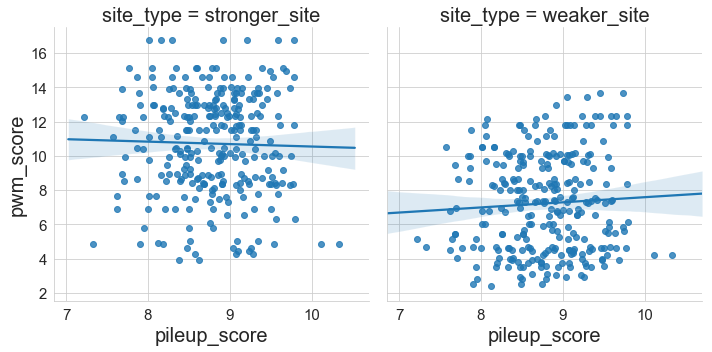

In [10]:
print("Pearson correlation\n",pwm_vs_chip_k562.groupby('site_type')[['pileup_score','pwm_score']].corr().iloc[0::2,-1])
sns.lmplot(x='pileup_score', y='pwm_score', col="site_type" , data=pwm_vs_chip_k562)

## 3. Random forest performance for ETS1-RUNX1

In [3]:
with open("../analysis_files/ETS1_RUNX1/model/ets1_runx1_rfmodel.sav", 'rb') as pickle_file:
    rf = pickle.load(pickle_file)

rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)